# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data represents one continuous marketing campaign over 5 years, from 2008-2013.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import time


In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
# Overall the data looks clean with no missing values, see ScratchPad at bottom of Notebook for evaluation details.
# 
# Based on the data description, and discussion with instructor Jessica during office hours, we will drop the "duration" feature as it is not known before the call is performed, and is highly correlated with the target variable.
# This is also recommended in the dataset documentation above, see #11.
df = df.drop(columns=['duration'])

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The business objective of the task is to apply and compare 4 different models (KNN, LR, DT, SVM) with suitable hyperparamter values, to forecast whether individual telemarketing calls to bank clients will succeed in selling long-term deposit products. The system helps marketing managers prioritize which clients to call based on predicted success.

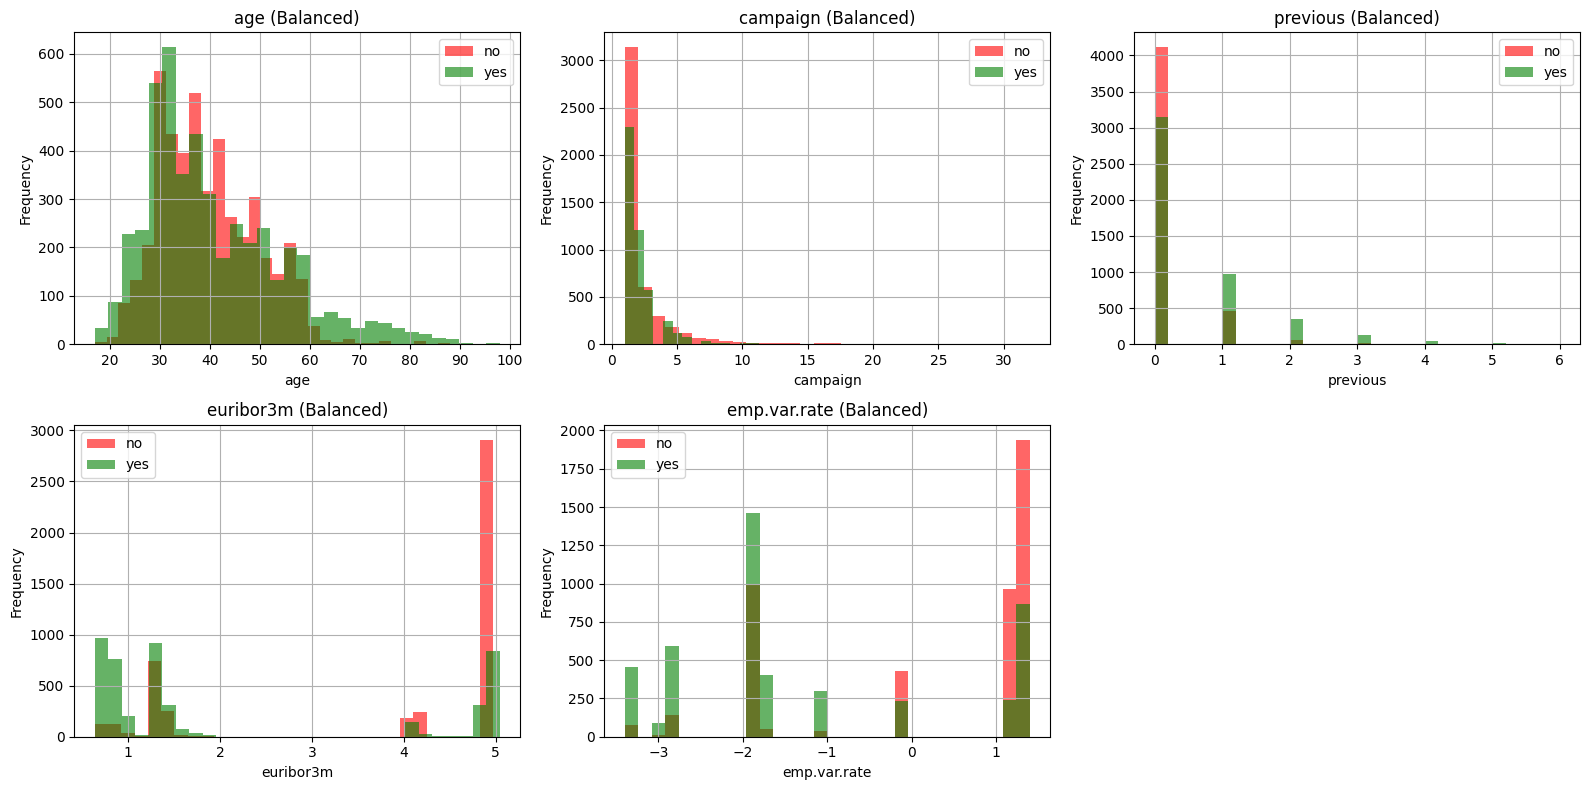

In [5]:
# Prepare data for visualization
X = df.drop('y', axis=1)
y = df['y']

categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Data is imbalanced, so try balancing the data using random sampling
df_balanced = pd.concat([
    df[df['y'] == 'no'].sample(n=len(df[df['y'] == 'yes']), random_state=42),
    df[df['y'] == 'yes']
])


# Create visualizations comparing top features for balanced data
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

# Get top 3 numerical features by importance (based on previous analysis)
top_numerical = ['age', 'campaign', 'previous', 'euribor3m', 'emp.var.rate']

for idx, col in enumerate(top_numerical):
    ax = axes[idx]
    df_balanced[df_balanced['y'] == 'no'][col].hist(bins=30, alpha=0.6, label='no', ax=ax, color='red')
    df_balanced[df_balanced['y'] == 'yes'][col].hist(bins=30, alpha=0.6, label='yes', ax=ax, color='green')
    ax.set_title(f'{col} (Balanced)')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()

# Remove extra subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [6]:
X = df.drop('y', axis=1)
y = df['y']

le = LabelEncoder()
y = le.fit_transform(y)

categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [8]:
# Create a baseline model 
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

baseline_train_score = baseline.score(X_train, y_train)
baseline_test_score = baseline.score(X_test, y_test)

print("Baseline Performance:")
print(f"Train Accuracy: {baseline_train_score:.4f}")
print(f"Test Accuracy: {baseline_test_score:.4f}")
print(f"Our classifier should aim to beat {baseline_test_score:.4f} test accuracy.")

Baseline Performance:
Train Accuracy: 0.8876
Test Accuracy: 0.8865
Our classifier should aim to beat 0.8865 test accuracy.


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [9]:
# Build a simple Logistic Regression model
lr_simple = LogisticRegression(max_iter=1000)
lr_pipeline_simple = Pipeline([
    ('preprocessor', preprocessor),
    ('Logistic Regression', lr_simple)
])

# Fit the model
lr_pipeline_simple.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('Logistic Regression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Problem 9: Score the Model

What is the accuracy of your model?

In [10]:
# Score the model
lr_train_score = lr_pipeline_simple.score(X_train, y_train)
lr_test_score = lr_pipeline_simple.score(X_test, y_test)

print("Logistic Regression Model Performance:")
print(f"Train Accuracy: {lr_train_score:.4f}")
print(f"Test Accuracy: {lr_test_score:.4f}")
print(f"\nCompared to Baseline ({baseline_test_score:.4f}), Logistic Regression ({lr_test_score:.4f}) is better!")

Logistic Regression Model Performance:
Train Accuracy: 0.9014
Test Accuracy: 0.8969

Compared to Baseline (0.8865), Logistic Regression (0.8969) is better!


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [ ]:
# Models with default hyperparameters
models = {
    'KNN': (KNeighborsClassifier(), {}),
    'Decision Tree': (DecisionTreeClassifier(), {}),
    'SVC': (SVC(), {}),
    'Logistic Regression': (LogisticRegression(), {})
}

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    # print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    # print(pipeline[:-1].get_feature_names_out)

    # Append the results
    results.append([name, fit_time, train_score, test_score])

    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

     # Extract feature importance based on model type
    if hasattr(best_model.named_steps[name], 'feature_importances_'):
        # For tree-based models (Decision Tree)
        importances = best_model.named_steps[name].feature_importances_
        top_indices = np.argsort(importances)[-5:][::-1]
        top_features = [(feature_names[i], importances[i]) for i in top_indices]
    elif hasattr(best_model.named_steps[name], 'coef_'):
        # For linear models (Logistic Regression, Ridge, Lasso)
        coef = np.abs(best_model.named_steps[name].coef_[0])
        top_indices = np.argsort(coef)[-5:][::-1]
        top_features = [(feature_names[i], coef[i]) for i in top_indices]
    else:
        # For KNN and SVM (no direct feature importance)
        top_features = [("Not available", np.nan) for _ in range(1)]
    
    print(f"\n{name} - Top 5 Features:")
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.4f}")

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Train time', 'Train Accuracy', 'Test Accuracy'])
results_df.set_index('Model', inplace=True)
results_df


KNN - Top 5 Features:
  Not available: nan

Decision Tree - Top 5 Features:
  num__age: 0.1695
  num__nr.employed: 0.1598
  num__euribor3m: 0.1025
  num__campaign: 0.0792
  cat__housing_yes: 0.0418

SVC - Top 5 Features:
  Not available: nan

Logistic Regression - Top 5 Features:
  num__emp.var.rate: 2.2200
  cat__month_mar: 1.4218
  num__cons.price.idx: 1.1170
  cat__contact_telephone: 0.7673
  cat__poutcome_success: 0.6572


,Train time,Train Accuracy,Test Accuracy
Model,,,
KNN,7.836838,0.914446,0.892085
Decision Tree,4.285767,0.995357,0.837582
SVC,165.781013,0.905432,0.897062
Logistic Regression,0.575776,0.901366,0.896941


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
models = {
    'KNN': (KNeighborsClassifier(), {'KNN__n_neighbors': [3, 5, 7, 10]}),
    'Decision Tree': (DecisionTreeClassifier(), {'Decision Tree__max_depth': [3, 5, 7, 10]}),
     # 'SVC': (SVC(), {'SVC__C': [0.1, 1.0, 3, 10], 'SVC__kernel': ['linear', 'rbf', 'sigmoid', 'poly'], 'SVC__gamma' : [0.1, 1.0, 10.0]}),
     # 'SVC': (SVC(), {'SVC__kernel': ['rbf'], 'SVC__gamma' : [0.1, 1.0, 10.0]}),
     # 'SVC': (SVC(), {'SVC__C': [0.1, 1, 10], 'SVC__kernel': ['rbf'], 'SVC__gamma' : ['scale', 0.1], 'SVC__class_weight' : ['balanced']}),
     # 'SVC': (SVC(), {'SVC__C': [0.1, 1, 10], 'SVC__kernel': ['rbf'], 'SVC__class_weight' : ['balanced']}),
     # 'SVC': (SVC(), {'SVC__C': [0.1, 1, 10], 'SVC__kernel': ['rbf']}),
     'SVC': (SVC(), {'SVC__C': [0.1, 1, 10], 'SVC__kernel': ['poly']}),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'Logistic Regression__C': [0.1, 1, 10, 100]}),
}

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    print(f"\nBest parameters for {name}: {grid_search.best_params_}")
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    # print(pipeline[:-1].get_feature_names_out)
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

     # Extract feature importance based on model type
    if hasattr(best_model.named_steps[name], 'feature_importances_'):
        # For tree-based models (Decision Tree)
        importances = best_model.named_steps[name].feature_importances_
        top_indices = np.argsort(importances)[-5:][::-1]
        top_features = [(feature_names[i], importances[i]) for i in top_indices]
    elif hasattr(best_model.named_steps[name], 'coef_'):
        # For linear models (Logistic Regression)
        coef = np.abs(best_model.named_steps[name].coef_[0])
        top_indices = np.argsort(coef)[-5:][::-1]
        top_features = [(feature_names[i], coef[i]) for i in top_indices]
    else:
        # For KNN and SVM (no direct feature importance)
        top_features = [("Not available", np.nan) for _ in range(1)]
    
    print(f"{name} - Top 5 Features:")
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.4f}")
    # Append the results
    results.append([name, fit_time, train_score, test_score])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Train time', 'Train Accuracy', 'Test Accuracy'])
results_df.set_index('Model', inplace=True)
results_df


Best parameters for KNN: {'KNN__n_neighbors': 10}
KNN - Top 5 Features:
  Not available: nan

Best parameters for Decision Tree: {'Decision Tree__max_depth': 5}
Decision Tree - Top 5 Features:
  num__nr.employed: 0.6380
  num__pdays: 0.1302
  num__cons.conf.idx: 0.0649
  num__euribor3m: 0.0542
  cat__contact_telephone: 0.0264

Best parameters for SVC: {'SVC__C': 0.1, 'SVC__kernel': 'poly'}
SVC - Top 5 Features:
  Not available: nan

Best parameters for Logistic Regression: {'Logistic Regression__C': 0.1}
Logistic Regression - Top 5 Features:
  num__emp.var.rate: 1.3579
  cat__month_mar: 1.1044
  num__cons.price.idx: 0.6457
  cat__contact_telephone: 0.6347
  cat__month_may: 0.5651


,Train time,Train Accuracy,Test Accuracy
Model,,,
KNN,6.100685,0.906798,0.894392
Decision Tree,0.276160,0.904492,0.896213
SVC,81.908721,0.901669,0.897548
Logistic Regression,0.305246,0.901396,0.897427


## Summary of Findings
1. From Test Accuracy perspective, Support Vector Machine (SVM) and Logistic Regression (LR), were the top 2 models, followed closely by Decision Tree (DT) and K Nearest Neighbor (KNN).
2. DT offer easy human interpretability, and the fastest training times. 
3. SVM is the slowest by far, and made experimenting with multiple parameters difficult.

### Layman summary
Based on the tuned models test accuracy, SVM scored the highest at 0.8975, so it offers the best results.
However, if human interpretability is important, Decision Tree (plotted below) offers comparable test accuracy at 0.8962.

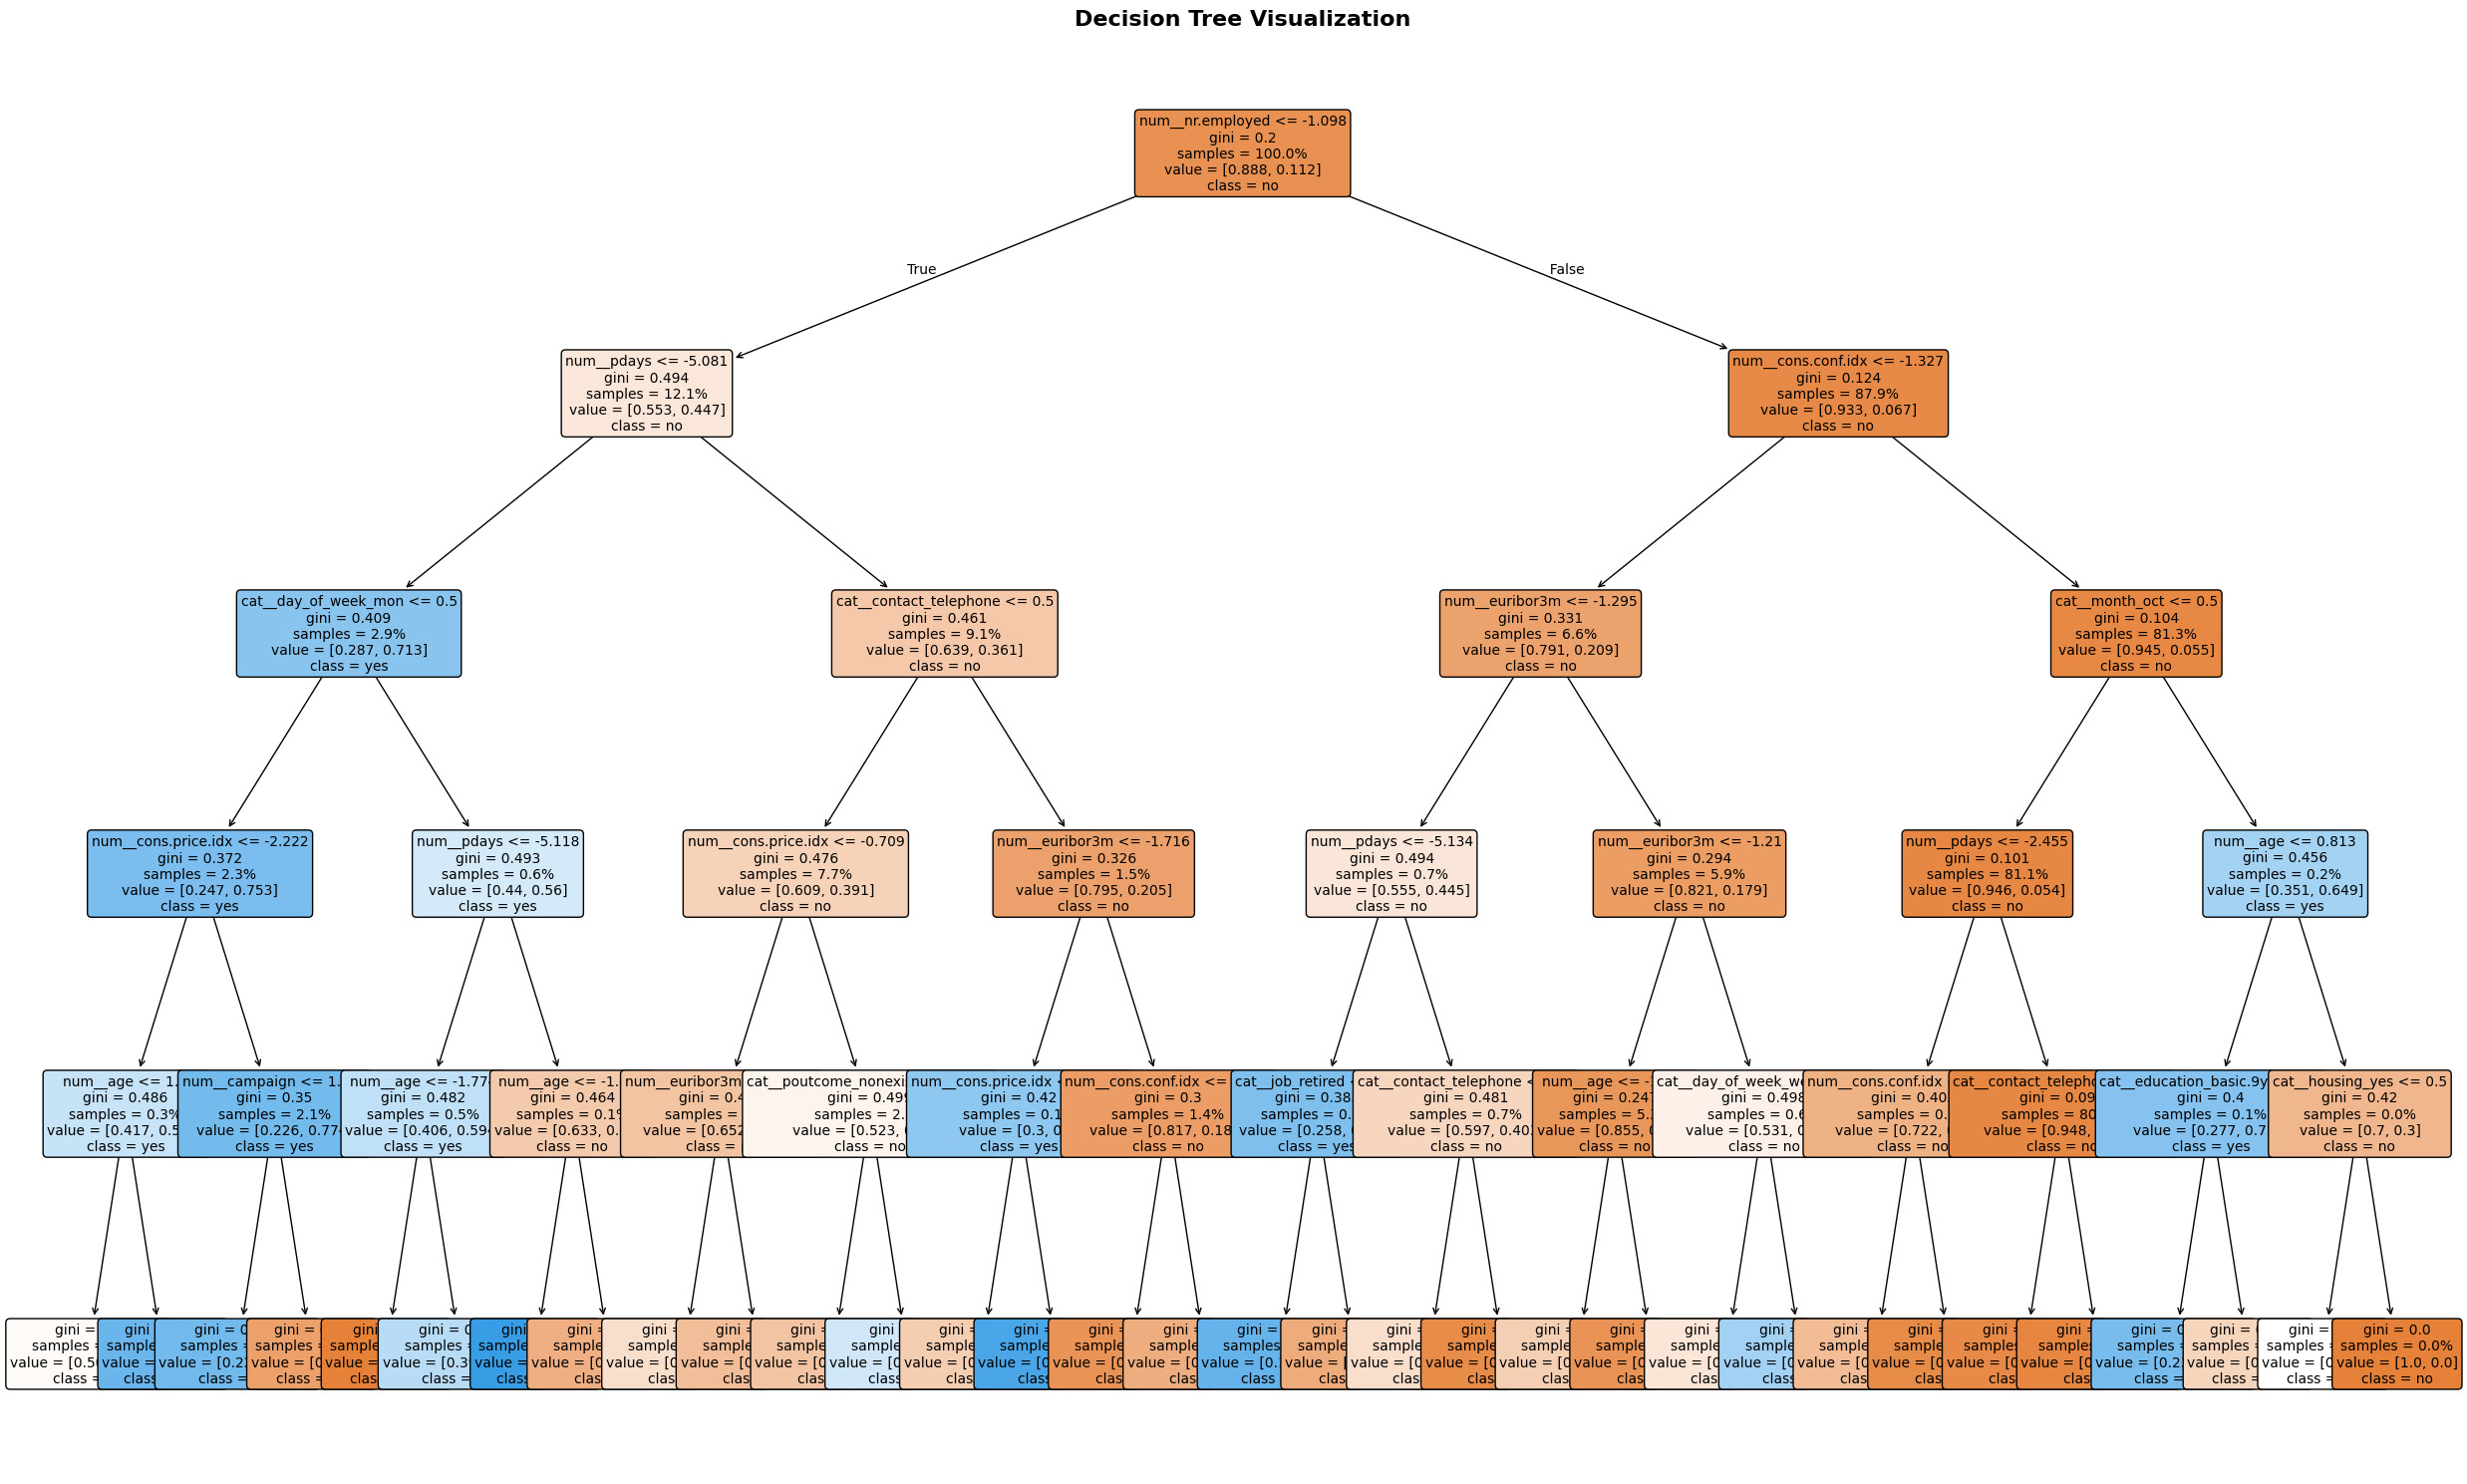

In [19]:
# Decision Tree Pipeline
dt_model = DecisionTreeClassifier(max_depth=5)
preprocessor_dt = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

pipeline_dt = Pipeline([
    ('preprocessor', preprocessor_dt),
    ('Decision Tree', dt_model)
])
pipeline_dt.fit(X_train, y_train)

# Plot the decision tree with better readability
plt.figure(figsize=(25, 15))
plot_tree(pipeline_dt.named_steps['Decision Tree'], 
          feature_names=pipeline_dt.named_steps['preprocessor'].get_feature_names_out().tolist(),
          class_names=['no', 'yes'],
          filled=True,
          rounded=True,
          fontsize=10,
          proportion=True)
plt.title("Decision Tree Visualization", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

##### Scratchpad

In [5]:
# Summary Stats. Source from Toby Gardner [https://github.com/toby-gardner-ai/uc-berkeley-aiml-course]
def summary_stats(df) -> pd.DataFrame:

    # Create base frame
    stats = pd.DataFrame(index=df.columns)

    stats["dtype"] = df.dtypes

    stats["sample_val"] = [df[col].dropna().sample(1).iloc[0]
                            if df[col].notna().any() else np.nan
                            for col in df.columns]

    stats["vals"] = df.count()
    stats["miss_pct"] = (df.isna().sum() / len(df) * 100).round(1)
    stats["unique"] = df.nunique()

    # Initiate Descriptive Stats
    for col in ["mean", "mode", "min", "max", "std", "skew", "kurtosis"]:
        stats[col] = np.nan

    # Compute stats for numeric columns
    num_cols = df.select_dtypes(include="number").columns

    for col in num_cols:
        s = df[col].dropna()
        if not s.empty:
            stats.at[col, "mean"] = s.mean()
            stats.at[col, "min"] = s.min()
            stats.at[col, "max"] = s.max()
            stats.at[col, "std"] = s.std()
            stats.at[col, "skew"] = s.skew().round(1)
            stats.at[col, "kurtosis"] = s.kurtosis().round(1)
            mode_vals = s.mode()
            stats.at[col, "mode"] = mode_vals.iloc[0] if not mode_vals.empty else np.nan

    # Rounding preferences for numeric stats (change this to suit dataset)
    round_cols = ["mean", "mode", "min", "max", "std"]
    stats[round_cols] = stats[round_cols].round(2)

    return stats

print(summary_stats(df))
print (df.dtypes)
print("isnull sum=\n", df.isnull().sum())

                  dtype   sample_val   vals  miss_pct  unique     mean  \
age               int64           25  41188       0.0      78    40.02   
job              object       admin.  41188       0.0      12      NaN   
marital          object      married  41188       0.0       4      NaN   
education        object      unknown  41188       0.0       8      NaN   
default          object           no  41188       0.0       3      NaN   
housing          object          yes  41188       0.0       3      NaN   
loan             object          yes  41188       0.0       3      NaN   
contact          object     cellular  41188       0.0       2      NaN   
month            object          may  41188       0.0      10      NaN   
day_of_week      object          tue  41188       0.0       5      NaN   
duration          int64          279  41188       0.0    1544   258.29   
campaign          int64            3  41188       0.0      42     2.57   
pdays             int64          999  